In [3]:
!pip install catboost

In [4]:
#Kütüphaneleri içe aktarıyoruz.
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
#Veriyi ortamımıza yüklüyoruz.
df = pd.read_csv("/content/breast_cancer.csv")

In [6]:
#Veriye genel bakış
def check_df(dataframe):
  print("################### Shape ##################")
  print(dataframe.shape)
  print("################### Types ##################")
  print(dataframe.dtypes)
  print("################### Head ##################")
  print(dataframe.head())
  print("################### Tail ##################")
  print(dataframe.tail())
  print("################### NA ##################")
  print(dataframe.isnull().sum())
  print("################### Quantiles ##################")
  print(dataframe.describe([0, 0.25, 0.50, 0.75, 0.99, 1]).T)

check_df(df)

################### Shape ##################
(569, 32)
################### Types ##################
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
                            ...   
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst             float64
fractal_dimension_worst    float64
Length: 32, dtype: object
################### Head ##################
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0    842302         M       17.990        10.380         122.800   1001.000            0.118             0.278           0.300                0.147          0.242   
1    842517         M       20.570        17.770         132.900   1326.000            0.085             0.079   

In [7]:
#Değişken türlerini belirliyoruz.
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                 dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                 dataframe[col].dtypes == "O"]

  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O" ]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols,num_but_cat

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 569
Variables: 32
cat_cols: 1
num_cols: 31
cat_but_car: 0
num_but_cat: 0


In [8]:
print(cat_cols)
print(num_cols)

['diagnosis']
['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [9]:
#Kategorik değişkenin analizi
def cat_summary(dataframe, col_name):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

cat_summary(df, "diagnosis")

           diagnosis  Ratio
diagnosis                  
B                357 62.742
M                212 37.258
##########################################


count         569.000
mean     30371831.432
std     125020585.612
min          8670.000
5%          90267.000
10%        853155.400
20%        863174.400
30%        875509.000
40%        894606.800
50%        906024.000
60%        915890.200
70%       8611964.800
80%       9010707.600
90%      88144221.800
95%      90424461.400
99%     901034301.320
max     911320502.000
Name: id, dtype: float64


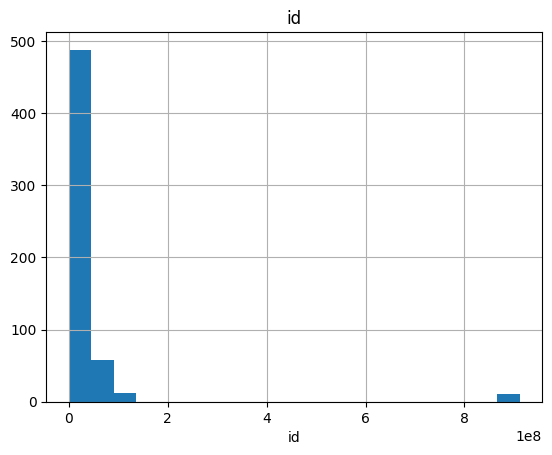

count   569.000
mean     14.127
std       3.524
min       6.981
5%        9.529
10%      10.260
20%      11.366
30%      12.012
40%      12.726
50%      13.370
60%      14.058
70%      15.056
80%      17.068
90%      19.530
95%      20.576
99%      24.372
max      28.110
Name: radius_mean, dtype: float64


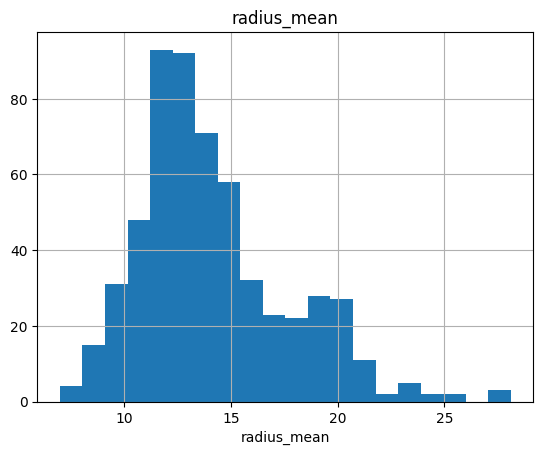

count   569.000
mean     19.290
std       4.301
min       9.710
5%       13.088
10%      14.078
20%      15.656
30%      16.840
40%      17.912
50%      18.840
60%      19.968
70%      21.272
80%      22.440
90%      24.992
95%      27.150
99%      30.652
max      39.280
Name: texture_mean, dtype: float64


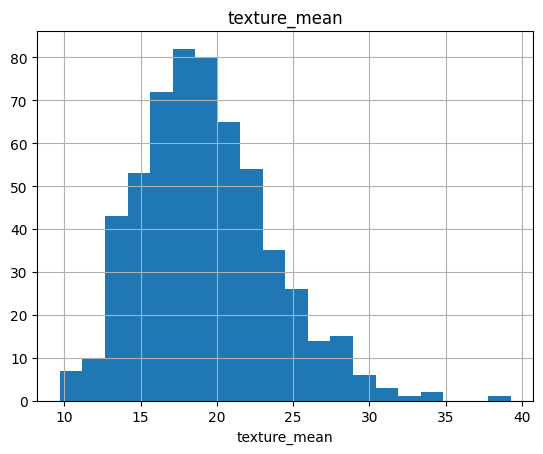

count   569.000
mean     91.969
std      24.299
min      43.790
5%       60.496
10%      65.830
20%      73.292
30%      77.360
40%      81.938
50%      86.240
60%      91.420
70%      98.200
80%     111.680
90%     129.100
95%     135.820
99%     165.724
max     188.500
Name: perimeter_mean, dtype: float64


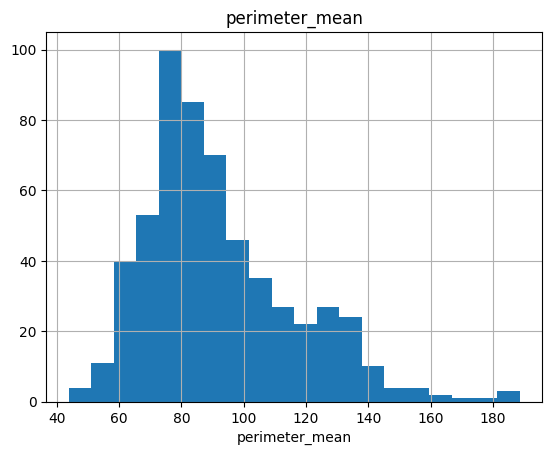

count    569.000
mean     654.889
std      351.914
min      143.500
5%       275.780
10%      321.600
20%      396.560
30%      444.060
40%      496.440
50%      551.100
60%      609.740
70%      700.660
80%      915.060
90%     1177.400
95%     1309.800
99%     1786.600
max     2501.000
Name: area_mean, dtype: float64


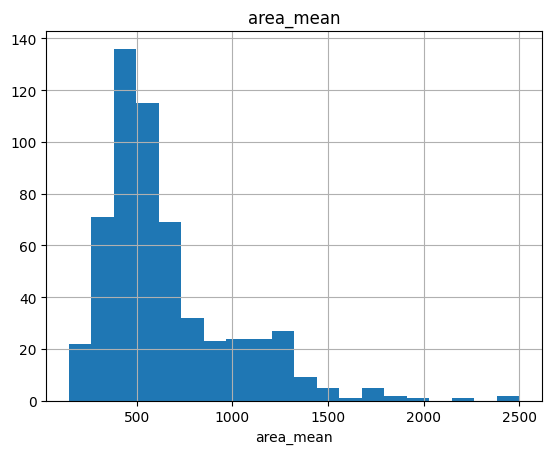

count   569.000
mean      0.096
std       0.014
min       0.053
5%        0.075
10%       0.080
20%       0.084
30%       0.088
40%       0.092
50%       0.096
60%       0.099
70%       0.103
80%       0.107
90%       0.115
95%       0.119
99%       0.133
max       0.163
Name: smoothness_mean, dtype: float64


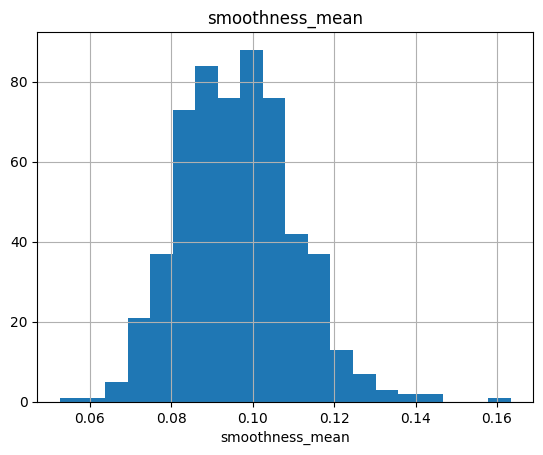

count   569.000
mean      0.104
std       0.053
min       0.019
5%        0.041
10%       0.050
20%       0.060
30%       0.070
40%       0.080
50%       0.093
60%       0.109
70%       0.122
80%       0.142
90%       0.175
95%       0.209
99%       0.277
max       0.345
Name: compactness_mean, dtype: float64


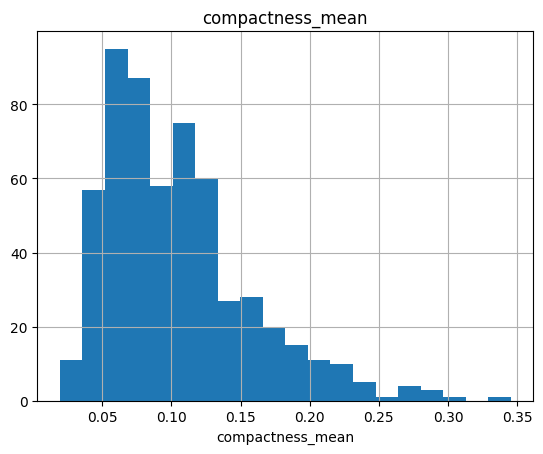

count   569.000
mean      0.089
std       0.080
min       0.000
5%        0.005
10%       0.014
20%       0.025
30%       0.034
40%       0.045
50%       0.062
60%       0.086
70%       0.112
80%       0.150
90%       0.203
95%       0.243
99%       0.352
max       0.427
Name: concavity_mean, dtype: float64


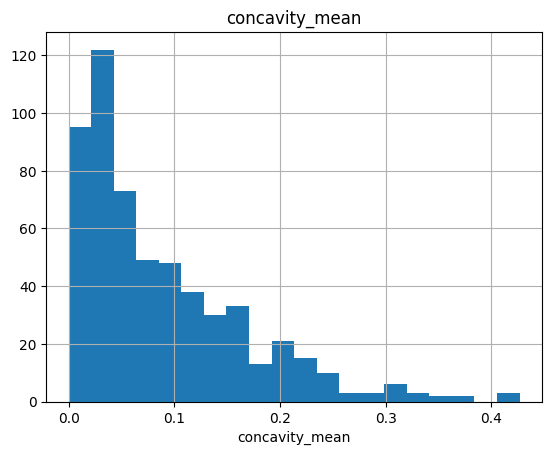

count   569.000
mean      0.049
std       0.039
min       0.000
5%        0.006
10%       0.011
20%       0.018
30%       0.023
40%       0.028
50%       0.034
60%       0.048
70%       0.064
80%       0.084
90%       0.100
95%       0.126
99%       0.164
max       0.201
Name: concave points_mean, dtype: float64


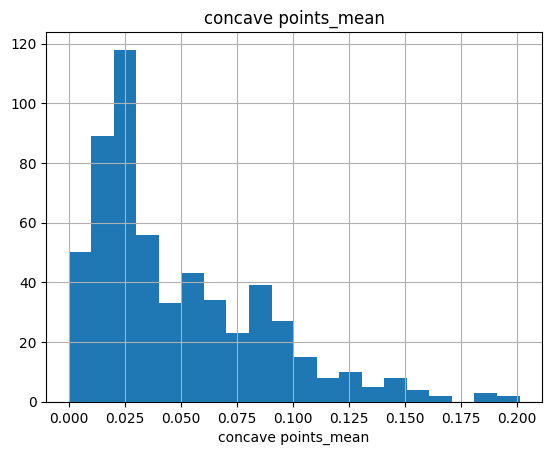

count   569.000
mean      0.181
std       0.027
min       0.106
5%        0.142
10%       0.150
20%       0.159
30%       0.165
40%       0.172
50%       0.179
60%       0.185
70%       0.193
80%       0.201
90%       0.215
95%       0.231
99%       0.260
max       0.304
Name: symmetry_mean, dtype: float64


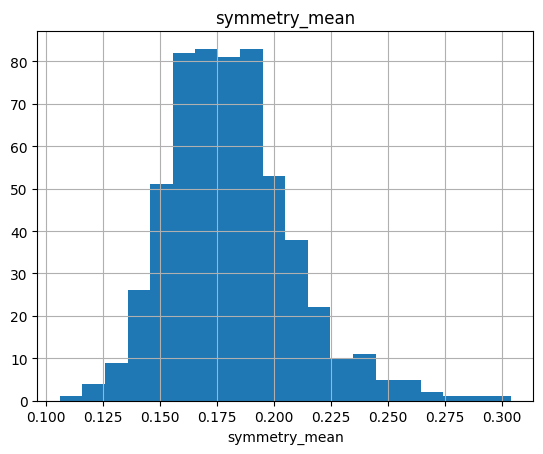

count   569.000
mean      0.063
std       0.007
min       0.050
5%        0.054
10%       0.055
20%       0.057
30%       0.059
40%       0.060
50%       0.062
60%       0.063
70%       0.065
80%       0.068
90%       0.072
95%       0.076
99%       0.085
max       0.097
Name: fractal_dimension_mean, dtype: float64


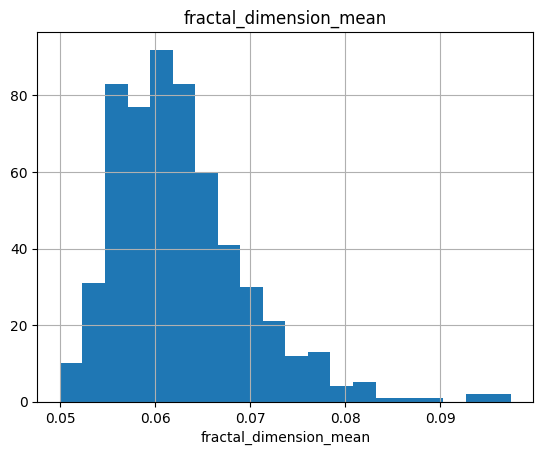

count   569.000
mean      0.405
std       0.277
min       0.112
5%        0.160
10%       0.183
20%       0.219
30%       0.246
40%       0.280
50%       0.324
60%       0.369
70%       0.431
80%       0.546
90%       0.749
95%       0.960
99%       1.291
max       2.873
Name: radius_se, dtype: float64


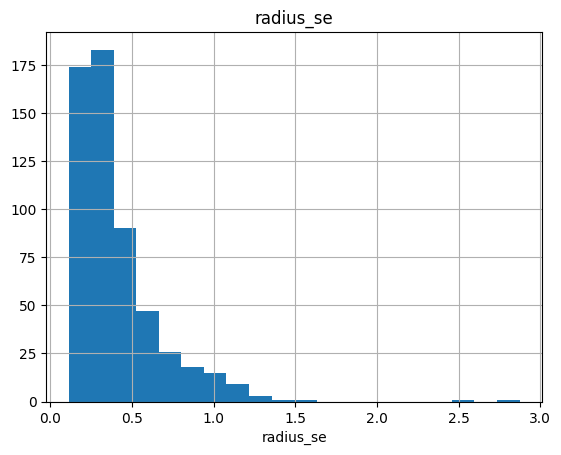

count   569.000
mean      1.217
std       0.552
min       0.360
5%        0.540
10%       0.640
20%       0.781
30%       0.902
40%       1.005
50%       1.108
60%       1.239
70%       1.388
80%       1.561
90%       1.909
95%       2.212
99%       2.915
max       4.885
Name: texture_se, dtype: float64


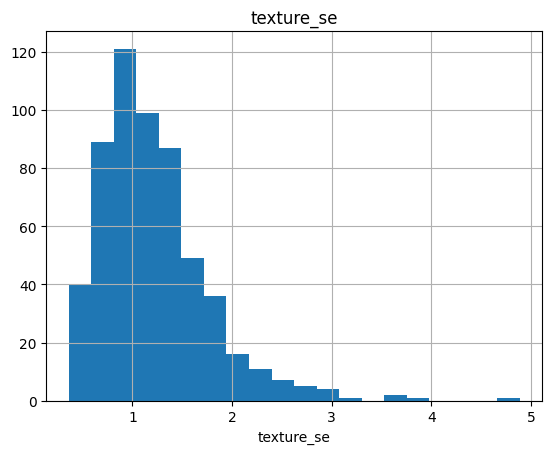

count   569.000
mean      2.866
std       2.022
min       0.757
5%        1.133
10%       1.280
20%       1.517
30%       1.741
40%       2.039
50%       2.287
60%       2.591
70%       3.050
80%       3.768
90%       5.123
95%       7.042
99%       9.690
max      21.980
Name: perimeter_se, dtype: float64


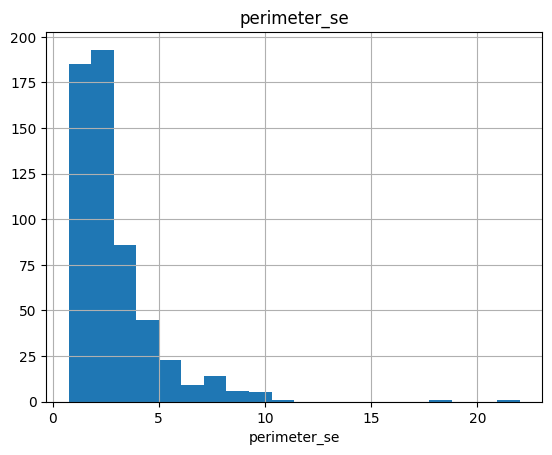

count   569.000
mean     40.337
std      45.491
min       6.802
5%       11.360
10%      13.160
20%      16.640
30%      19.038
40%      21.078
50%      24.530
60%      29.322
70%      38.430
80%      54.088
90%      91.314
95%     115.800
99%     177.684
max     542.200
Name: area_se, dtype: float64


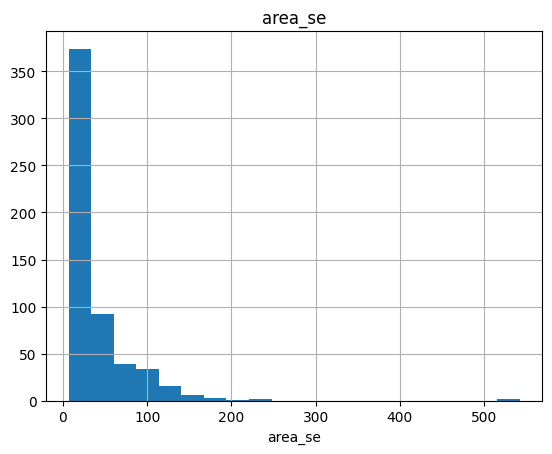

count   569.000
mean      0.007
std       0.003
min       0.002
5%        0.004
10%       0.004
20%       0.005
30%       0.005
40%       0.006
50%       0.006
60%       0.007
70%       0.008
80%       0.009
90%       0.010
95%       0.013
99%       0.017
max       0.031
Name: smoothness_se, dtype: float64


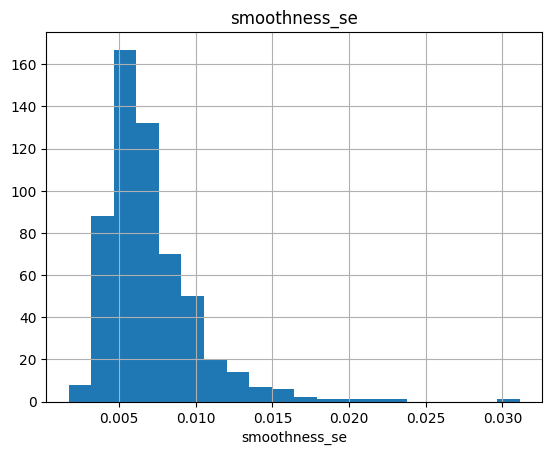

count   569.000
mean      0.025
std       0.018
min       0.002
5%        0.008
10%       0.009
20%       0.012
30%       0.014
40%       0.017
50%       0.020
60%       0.024
70%       0.030
80%       0.036
90%       0.048
95%       0.061
99%       0.090
max       0.135
Name: compactness_se, dtype: float64


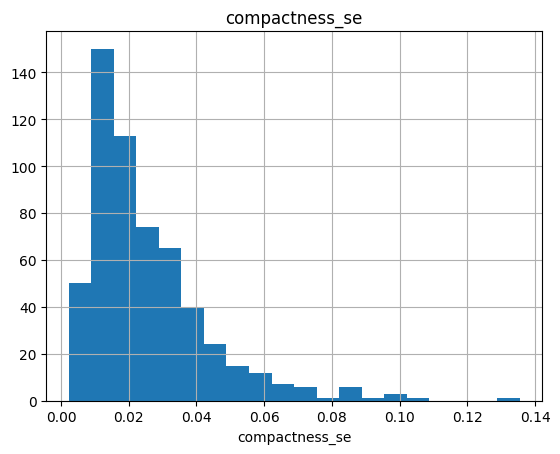

count   569.000
mean      0.032
std       0.030
min       0.000
5%        0.003
10%       0.008
20%       0.013
30%       0.017
40%       0.020
50%       0.026
60%       0.031
70%       0.037
80%       0.046
90%       0.059
95%       0.079
99%       0.122
max       0.396
Name: concavity_se, dtype: float64


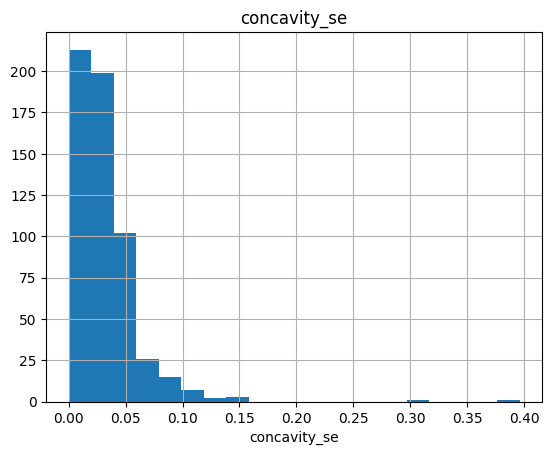

count   569.000
mean      0.012
std       0.006
min       0.000
5%        0.004
10%       0.005
20%       0.007
30%       0.008
40%       0.010
50%       0.011
60%       0.012
70%       0.014
80%       0.016
90%       0.019
95%       0.023
99%       0.031
max       0.053
Name: concave points_se, dtype: float64


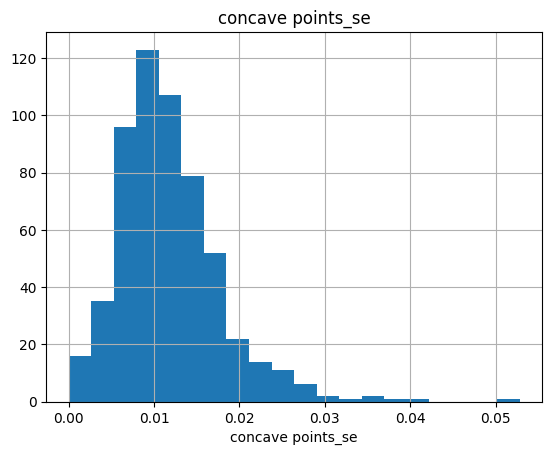

count   569.000
mean      0.021
std       0.008
min       0.008
5%        0.012
10%       0.013
20%       0.015
30%       0.016
40%       0.017
50%       0.019
60%       0.020
70%       0.022
80%       0.026
90%       0.030
95%       0.035
99%       0.052
max       0.079
Name: symmetry_se, dtype: float64


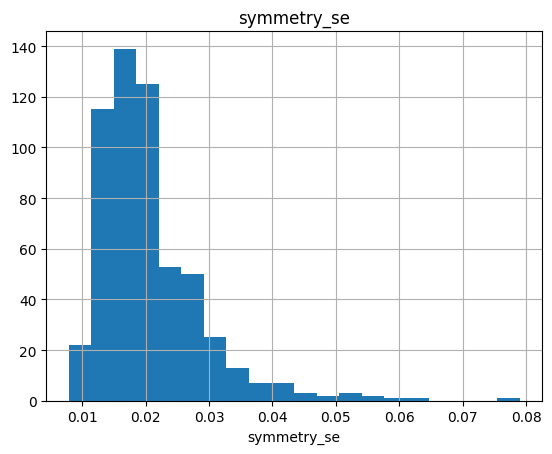

count   569.000
mean      0.004
std       0.003
min       0.001
5%        0.002
10%       0.002
20%       0.002
30%       0.002
40%       0.003
50%       0.003
60%       0.004
70%       0.004
80%       0.005
90%       0.006
95%       0.008
99%       0.013
max       0.030
Name: fractal_dimension_se, dtype: float64


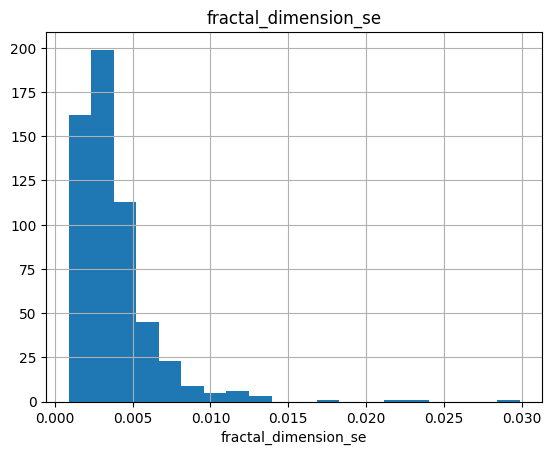

count   569.000
mean     16.269
std       4.833
min       7.930
5%       10.534
10%      11.234
20%      12.498
30%      13.314
40%      14.008
50%      14.970
60%      16.004
70%      17.386
80%      20.294
90%      23.682
95%      25.640
99%      30.763
max      36.040
Name: radius_worst, dtype: float64


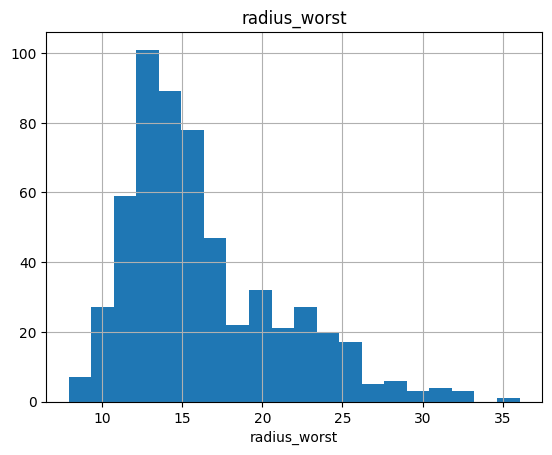

count   569.000
mean     25.677
std       6.146
min      12.020
5%       16.574
10%      17.800
20%      20.176
30%      21.988
40%      23.584
50%      25.410
60%      26.724
70%      28.460
80%      30.908
90%      33.646
95%      36.300
99%      41.802
max      49.540
Name: texture_worst, dtype: float64


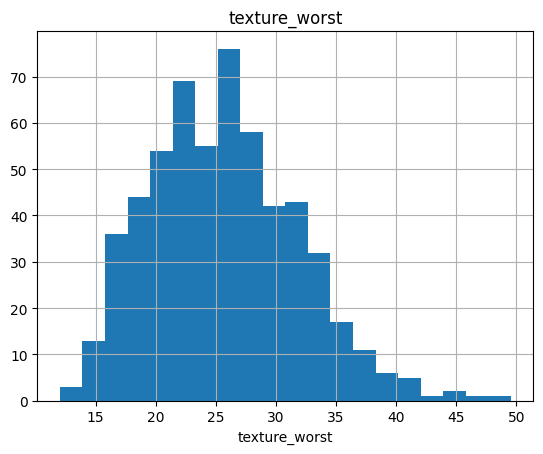

count   569.000
mean    107.261
std      33.603
min      50.410
5%       67.856
10%      72.178
20%      81.402
30%      86.328
40%      91.304
50%      97.660
60%     105.740
70%     115.900
80%     133.500
90%     157.740
95%     171.640
99%     208.304
max     251.200
Name: perimeter_worst, dtype: float64


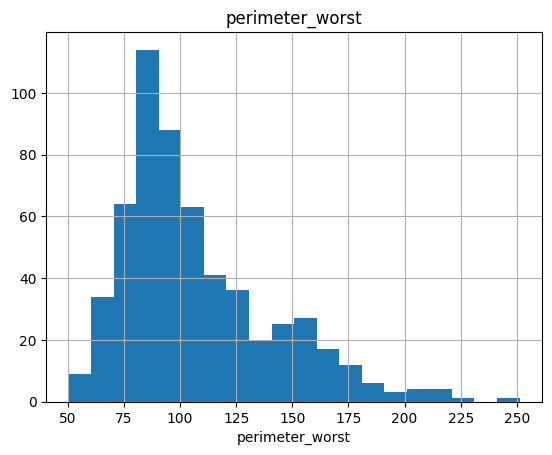

count    569.000
mean     880.583
std      569.357
min      185.200
5%       331.060
10%      384.720
20%      475.980
30%      544.140
40%      599.700
50%      686.500
60%      781.180
70%      926.960
80%     1269.000
90%     1673.000
95%     2009.600
99%     2918.160
max     4254.000
Name: area_worst, dtype: float64


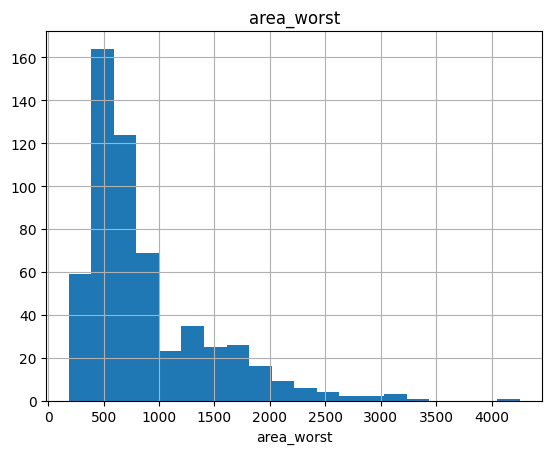

count   569.000
mean      0.132
std       0.023
min       0.071
5%        0.096
10%       0.103
20%       0.113
30%       0.121
40%       0.126
50%       0.131
60%       0.138
70%       0.143
80%       0.150
90%       0.161
95%       0.172
99%       0.189
max       0.223
Name: smoothness_worst, dtype: float64


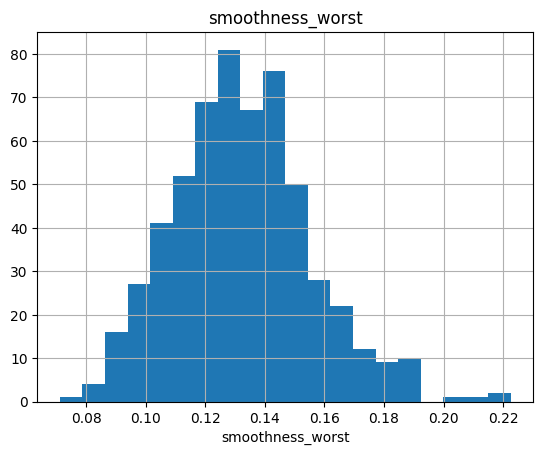

count   569.000
mean      0.254
std       0.157
min       0.027
5%        0.071
10%       0.094
20%       0.126
30%       0.161
40%       0.185
50%       0.212
60%       0.251
70%       0.304
80%       0.367
90%       0.448
95%       0.564
99%       0.779
max       1.058
Name: compactness_worst, dtype: float64


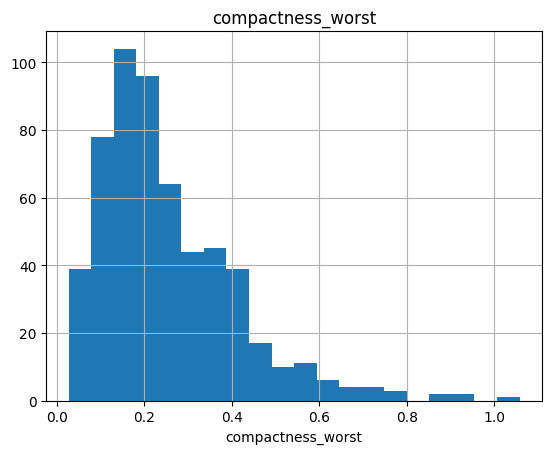

count   569.000
mean      0.272
std       0.209
min       0.000
5%        0.018
10%       0.046
20%       0.092
30%       0.137
40%       0.177
50%       0.227
60%       0.287
70%       0.350
80%       0.420
90%       0.571
95%       0.682
99%       0.902
max       1.252
Name: concavity_worst, dtype: float64


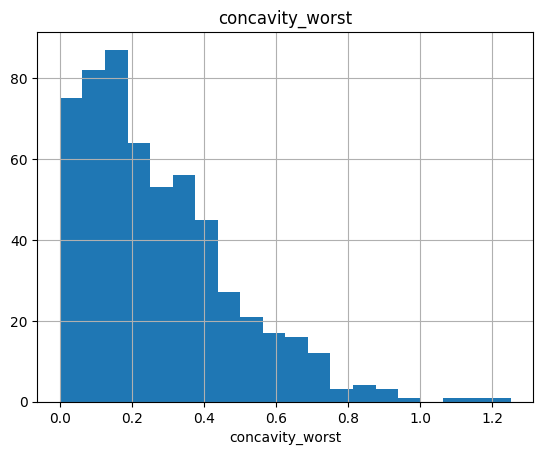

count   569.000
mean      0.115
std       0.066
min       0.000
5%        0.024
10%       0.038
20%       0.058
30%       0.072
40%       0.084
50%       0.100
60%       0.122
70%       0.151
80%       0.178
90%       0.209
95%       0.237
99%       0.269
max       0.291
Name: concave points_worst, dtype: float64


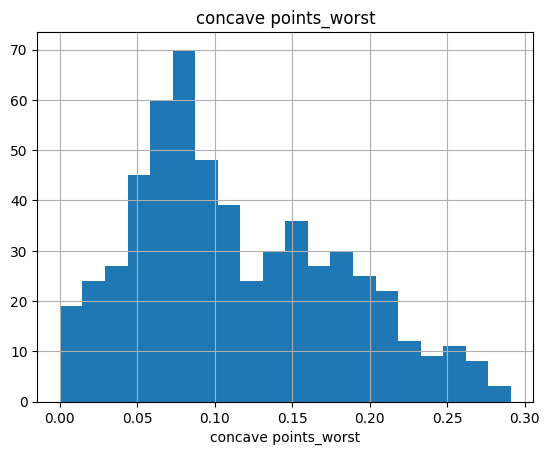

count   569.000
mean      0.290
std       0.062
min       0.157
5%        0.213
10%       0.226
20%       0.244
30%       0.257
40%       0.269
50%       0.282
60%       0.296
70%       0.310
80%       0.325
90%       0.360
95%       0.406
99%       0.487
max       0.664
Name: symmetry_worst, dtype: float64


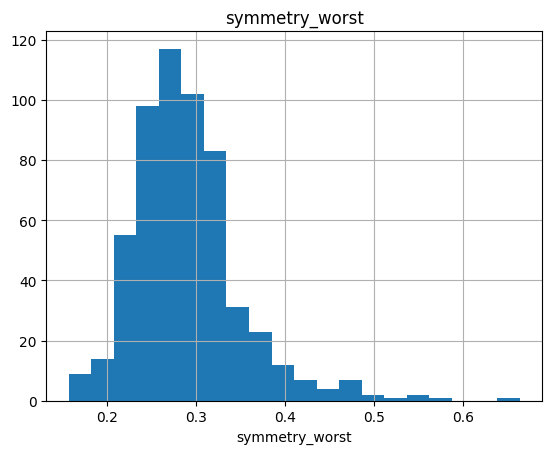

count   569.000
mean      0.084
std       0.018
min       0.055
5%        0.063
10%       0.066
20%       0.070
30%       0.073
40%       0.077
50%       0.080
60%       0.083
70%       0.089
80%       0.096
90%       0.106
95%       0.120
99%       0.141
max       0.207
Name: fractal_dimension_worst, dtype: float64


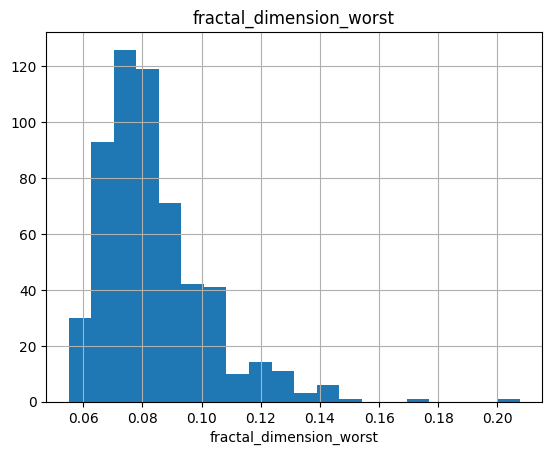

In [10]:

#Numerik değişken analizi
def num_summary(dataframe, numerical_col, plot=False):
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[numerical_col].describe(quantiles).T)
  if plot:
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.title(numerical_col)
    plt.show(block=True)

for col in num_cols:
  num_summary(df, col, plot=True)

In [11]:
#Hedef değişkenin numerik değişkenlere göre analizi.
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "diagnosis", col)

                    id
diagnosis             
B         26543824.625
M         36818050.443


           radius_mean
diagnosis             
B               12.147
M               17.463


           texture_mean
diagnosis              
B                17.915
M                21.605


           perimeter_mean
diagnosis                
B                  78.075
M                 115.365


           area_mean
diagnosis           
B            462.790
M            978.376


           smoothness_mean
diagnosis                 
B                    0.092
M                    0.103


           compactness_mean
diagnosis                  
B                     0.080
M                     0.145


           concavity_mean
diagnosis                
B                   0.046
M                   0.161


           concave points_mean
diagnosis                     
B                        0.026
M                        0.088


           symmetry_mean
diagnosis               
B               

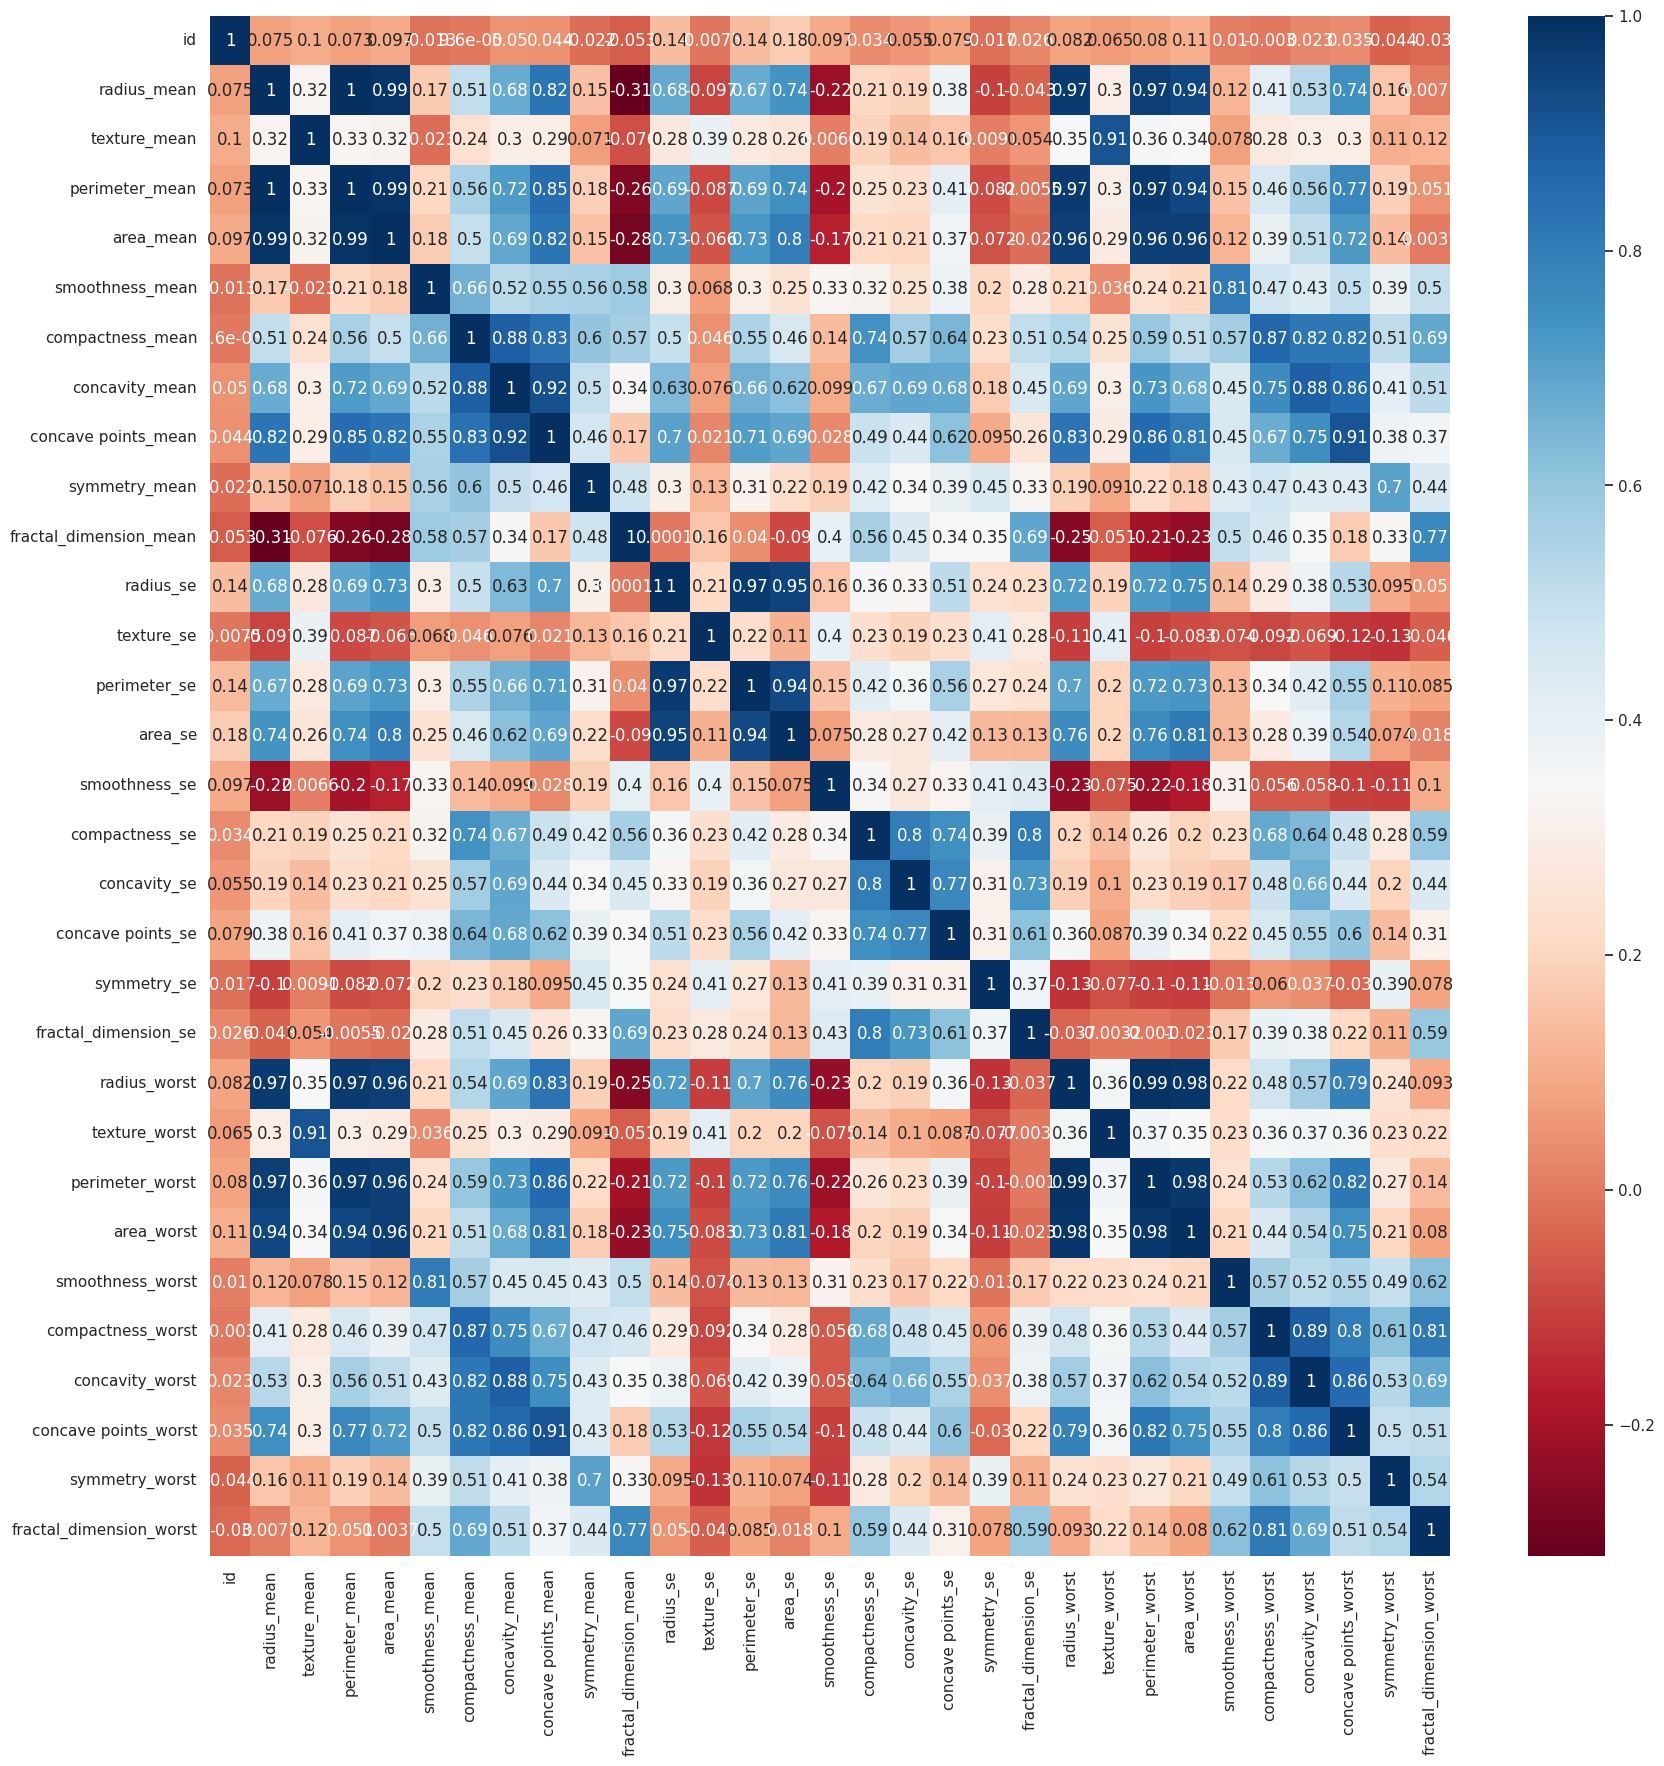

In [12]:
#Korelasyon analizi
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

In [13]:
#Birbirleri arasında yüksek korelasyona sahip değişkenler
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):

    dataframe = df.select_dtypes(include=[np.number])

    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show(block=True)
    return drop_list
high_correlated_cols(df, plot=False)

['perimeter_mean',
 'area_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'fractal_dimension_worst']

In [14]:
#Aykırı değer analizi
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquantile_range = quartile3 - quartile1
  up_limit = quartile3 + 1.5*interquantile_range
  low_limit = quartile1 - 1.5*interquantile_range
  return low_limit, up_limit

def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

for col in num_cols:
    print(col, check_outlier(df, col))

id True
radius_mean True
texture_mean True
perimeter_mean True
area_mean True
smoothness_mean True
compactness_mean True
concavity_mean True
concave points_mean True
symmetry_mean True
fractal_dimension_mean True
radius_se True
texture_se True
perimeter_se True
area_se True
smoothness_se True
compactness_se True
concavity_se True
concave points_se True
symmetry_se True
fractal_dimension_se True
radius_worst True
texture_worst True
perimeter_worst True
area_worst True
smoothness_worst True
compactness_worst True
concavity_worst True
concave points_worst False
symmetry_worst True
fractal_dimension_worst True


In [15]:
#Aykırı değerleri baskılıyoruz.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

<ipython-input-15-db8d4c3fa79d>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-11046648.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


id False
radius_mean False
texture_mean False
perimeter_mean False
area_mean False
smoothness_mean False
compactness_mean False
concavity_mean False
concave points_mean False
symmetry_mean False
fractal_dimension_mean False
radius_se False
texture_se False
perimeter_se False
area_se False
smoothness_se False
compactness_se False
concavity_se False
concave points_se False
symmetry_se False
fractal_dimension_se False
radius_worst False
texture_worst False
perimeter_worst False
area_worst False
smoothness_worst False
compactness_worst False
concavity_worst False
concave points_worst False
symmetry_worst False
fractal_dimension_worst False


In [16]:
#Veri setindeki toplam boş değerlere bakıyoruz
df.isnull().sum().sum()

0

In [17]:
#Kategorik verileri sayısal değerlere çevirir.
label_encoder = LabelEncoder()
df['diagnosis'] = label_encoder.fit_transform(df['diagnosis'])

In [18]:
#Veri setindeki değerleri modelimizin okuyabiliceği şekile getiriyoruz.
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.603,1,1.177,-2.121,1.357,1.184,1.619,2.541,2.647,2.621,2.349,2.512,2.281,-0.604,2.343,2.111,-0.198,1.639,1.152,0.779,1.520,1.463,2.006,-1.375,2.440,2.288,1.345,2.642,2.246,2.296,2.444,2.225
1,-0.603,1,1.950,-0.355,1.796,2.249,-0.843,-0.498,-0.000,0.575,0.018,-0.925,0.781,-0.957,0.499,1.612,-0.686,-0.769,-0.556,0.328,-0.938,-0.033,1.921,-0.370,1.632,2.288,-0.377,-0.443,-0.138,1.087,-0.234,0.355
2,2.212,1,1.686,0.477,1.670,1.846,0.975,1.149,1.496,2.110,1.005,-0.408,1.774,-0.848,1.345,2.111,-0.301,1.038,0.403,1.638,0.374,0.551,1.612,-0.020,1.434,1.808,0.547,1.223,0.921,1.955,1.369,0.265
3,2.212,1,-0.792,0.269,-0.606,-0.831,2.738,2.541,2.092,1.507,2.521,2.518,0.545,-0.087,0.532,-0.318,0.928,2.474,1.292,1.289,2.423,2.492,-0.278,0.141,-0.245,-0.594,2.596,2.642,2.119,2.176,2.444,2.482
4,2.212,1,1.866,-1.175,1.892,2.154,0.295,0.599,1.504,1.483,0.006,-0.589,1.831,-0.859,1.954,2.111,1.916,0.003,1.306,1.322,-0.379,0.857,1.387,-1.484,1.425,1.526,0.233,-0.314,0.665,0.729,-0.952,-0.411
5,-0.603,1,-0.483,-0.850,-0.390,-0.533,2.306,1.353,0.960,0.860,1.074,2.109,-0.247,-0.635,-0.344,-0.320,0.263,0.595,0.325,-0.042,0.244,0.838,-0.156,-0.314,-0.104,-0.228,2.103,1.927,1.352,0.906,2.060,2.482
6,-0.603,1,1.255,0.173,1.218,1.312,-0.120,0.117,0.349,0.677,-0.051,-0.808,0.305,-0.876,0.343,0.781,-1.064,-0.719,-0.365,-0.221,-0.968,-0.794,1.461,0.333,1.456,1.591,0.538,0.054,0.556,1.197,0.347,0.021
7,2.212,1,-0.106,0.377,-0.058,-0.203,1.655,1.242,0.091,0.300,1.492,1.857,0.977,0.369,0.825,0.659,0.801,0.384,-0.251,0.525,-0.790,1.024,0.191,0.412,0.122,0.099,1.488,0.829,-0.005,0.624,0.594,1.987
8,-0.603,1,-0.319,0.613,-0.176,-0.393,2.270,1.824,1.340,1.196,2.084,1.760,-0.385,-0.404,-0.209,-0.438,-0.475,0.700,0.267,0.120,0.211,0.089,-0.151,0.840,-0.016,-0.233,1.708,2.033,1.370,1.392,2.444,1.493
9,2.212,1,-0.480,1.144,-0.329,-0.537,1.633,2.541,1.901,0.981,0.855,2.518,-0.428,0.827,-0.471,-0.454,0.114,2.474,2.305,0.496,-0.328,2.492,-0.239,2.485,-0.284,-0.291,2.381,2.642,2.619,1.620,2.444,2.482


In [19]:
dff = df.copy()

In [20]:
#Bütün modellerin doğruluk oranlarını karşılaştırıyoruz.
y = dff["diagnosis"]
X = dff.drop(["diagnosis"], axis = 1)

models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ("XGBoost", XGBClassifier(objective='reg:squarederror')),
          ("CatBoost", CatBoostClassifier(verbose=False))]

for name, classifier in models:
    accuracy = np.mean(cross_val_score(classifier, X, y, cv=10, scoring="accuracy"))
    print(f"Accuracy: {round(accuracy, 4)} ({name})")

Accuracy: 0.9807 (LR)
Accuracy: 0.9701 (KNN)
Accuracy: 0.8961 (CART)
Accuracy: 0.9596 (RF)
Accuracy: 0.9578 (GBM)
Accuracy: 0.9455 (XGBoost)
Accuracy: 0.9754 (CatBoost)


In [21]:
#Kullanacağımız modeli kuruyoruz
y = df["diagnosis"]
X = df.drop(["diagnosis"], axis = 1)

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=42)

LR_model = LogisticRegression(random_state=42).fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.9824561403508771

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

